# Определение перспективного тарифа для телеком компании
<hr>
**Задача**

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.


|             Услуги               |    Смарт     |   Ультра     |
|----------------------------------|--------------|--------------|
|Ежемесячная плата, руб.           |    550       |   1950       |
|Включено: мин/смс/Гб              |   500/50/15  | 3000/1000/30 |
|Сверх пакета, ру.: мин/смс/Гб     |   3/3/200    |   1/1/150    |

**Описание данных**

*Таблица users (информация о пользователях):*
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

*Таблица calls (информация о звонках):*
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


*Таблица tariffs (информация о тарифах):*
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


# 1. **Общая информация о данных**

Открываем файлы с данными и изучаем общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
for data in [calls, internet, messages, users, tariffs]: 
    display(data.info())
    (print('*' * 85))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

*************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

*************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

*************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

*************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

*************************************************************************************


У нас есть данные по 500 клиентам.

- В таблице `users`, столбцах `reg_date`, `churn_date`, в таблице `internet`, столбце `session_date`, в таблице `messages`, столбце `message_date`, в таблице `calls`, столбце `call_date`, нужно заменить тип данных на datetime.
- Необходимо округлить минуты и интернет трафик в большую сторону, в соответствии с механизмом списания.

После объединения могут возникнуть пропущенные значения, не забываем об этом.

# 2. **Подготовка данных**

Приводим данные к нужным типам, ищем ошибки.

In [3]:
time_cols = [calls['call_date'], internet['session_date'], messages['message_date'], users['churn_date'], users['reg_date']]
for col in time_cols:
    col = pd.to_datetime(col, format='%Y-%m-%d')

In [4]:
for data in [calls, internet, messages, users, tariffs]: 
    display(data.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Видим, что есть звонки, длительность которых равна 0. Проверим, много ли таких значений.

In [5]:
calls.loc[calls['duration'] == 0, 'duration'].value_counts()

0.0    39613
Name: duration, dtype: int64

У нас есть нули в столбцах с использованными Гб и длительностью звонков. Есть ненужный unnamed столбец в таблице internet - удалим его. 

In [6]:
internet = internet.drop('Unnamed: 0', axis=1)
internet.dtypes

id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

Добавим столбец с датами в таблицы с смс, звонками и треффиком.

In [7]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

Приведем тип данных в столбце `user_id` к типу int

In [8]:
messages['user_id'] = messages['user_id'].astype('int')

Отразим информацию о тарифах в бинарном виде.

In [9]:
users['tariff_id'] = users['tariff'].apply(lambda x: 1 if x == 'ultra' else 0)
users['tariff_id'].value_counts()

0    351
1    149
Name: tariff_id, dtype: int64

Округлим все значения в большую сторону (т.к. тариф считается по минутам и по мегабайтам), а нулевые значения заменим на 1.

In [10]:
calls['duration'] = calls['duration'].apply(np.ceil).replace(0, 1)
internet['mb_used'] = internet['mb_used'].apply(np.ceil).replace(0, 1)

Интернет приведем в Гб для удобства дальнейшей обработки.

In [11]:
internet['gb_used'] = internet['mb_used'] / 1024

**Посчитаем для каждого пользователя:**

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Создадим три сводные таблицы (по смс, траффику, минутами) и объединим их в одну.

In [12]:
users_messages = messages.merge(users, on='user_id', how='inner')
messages_grouped = users_messages.pivot_table(values='id', 
                       index=['user_id', 'month',], 
                       aggfunc={'user_id': 'count'})
messages_grouped.columns = ['messages']
messages_grouped.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

In [13]:
users_calls = calls.merge(users, on='user_id', how='inner')
calls_grouped = users_calls.pivot_table(values=['duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'user_id': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']
calls_grouped.head()

duration  calls
user_id month                 
1000    5         164.0     22
        6         187.0     43
        7         346.0     47
        8         418.0     52
        9         478.0     58

In [14]:
users_internet = internet.merge(users, on='user_id', how='inner')
internet_grouped = users_internet.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']
internet_grouped.head()

mb_used
user_id month         
1000    5       2257.0
        6      23262.0
        7      14017.0
        8      14072.0
        9      14583.0

In [15]:
all_services = calls_grouped.merge(messages_grouped, how='outer', on=['user_id', 'month'])
all_services = all_services.merge(internet_grouped, how='outer', on=['user_id', 'month'])
all_services.reset_index(level=[0,1], inplace=True)
all_services.head()

,user_id,month,duration,calls,messages,mb_used
0,1000,5,164.0,22.0,22.0,2257.0
1,1000,6,187.0,43.0,60.0,23262.0
2,1000,7,346.0,47.0,75.0,14017.0
3,1000,8,418.0,52.0,81.0,14072.0
4,1000,9,478.0,58.0,57.0,14583.0


Добавили тариф

In [16]:
all_services = all_services.merge(users[['user_id', 'tariff_id']], on='user_id', how='left')
all_services

,user_id,month,duration,calls,messages,mb_used,tariff_id
0,1000,5,164.0,22.0,22.0,2257.0,1
1,1000,6,187.0,43.0,60.0,23262.0,1
2,1000,7,346.0,47.0,75.0,14017.0,1
3,1000,8,418.0,52.0,81.0,14072.0,1
4,1000,9,478.0,58.0,57.0,14583.0,1
...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17246.0,0
3210,1489,10,NaN,NaN,21.0,19599.0,0
3211,1489,11,NaN,NaN,20.0,17526.0,0
3212,1489,12,NaN,NaN,35.0,17349.0,0


In [17]:
all_services.loc[all_services['duration'].isna(), 'duration'] = 0
all_services.loc[all_services['messages'].isna(), 'messages'] = 0
all_services.loc[all_services['mb_used'].isna(), 'mb_used'] = 0

После формирования датафрейма по месяцам появились пропуски. Некоторые пользователи в некоторые месяцы пользовались не всеми услугами. Например, кто-то только мобильным интернетом. Заполним пропуски нулями и позже посмотрим на распределение.

In [18]:
na_= ['calls', 'duration', 'messages', 'mb_used']

for _ in na_:
    all_services[_] = all_services[_].fillna(0).astype('int64')

In [19]:
all_services.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id      3214 non-null int64
month        3214 non-null int64
duration     3214 non-null int64
calls        3214 non-null int64
messages     3214 non-null int64
mb_used      3214 non-null int64
tariff_id    3214 non-null int64
dtypes: int64(7)
memory usage: 200.9 KB


Создадим функцию для расчёта выручки

In [20]:
def revenue(row):
    duration = row['duration']
    calls = row['calls']
    msg = row['messages']
    mb = row['mb_used']
    tariff = row['tariff_id']
    surplus = []
    
    if tariff == 0:
        surplus.append(duration - tariffs.loc[0, 'minutes_included'])
        surplus.append(mb - tariffs.loc[0, 'mb_per_month_included'])
        surplus.append(msg - tariffs.loc[0, 'messages_included'])
        x = [0 if x < 0 else x for x in surplus]
        
        return x[2] * tariffs.loc[0, 'rub_per_message'] + math.ceil(x[1] / 1024) * tariffs.loc[0, 'rub_per_gb'] + x[0] * tariffs.loc[0, 'rub_per_minute'] + tariffs.loc[0, 'rub_monthly_fee'] 
        
    else:
        surplus.append(duration - tariffs.loc[1, 'minutes_included'])
        surplus.append(mb - tariffs.loc[1, 'mb_per_month_included'])
        surplus.append(msg - tariffs.loc[1, 'messages_included'])
        x = [0 if x < 0 else x for x in surplus]
        return x[2] * tariffs.loc[1, 'rub_per_message'] +  math.ceil(x[1] / 1024) * tariffs.loc[1, 'rub_per_gb'] + x[0] * tariffs.loc[1, 'rub_per_minute'] + tariffs.loc[1, 'rub_monthly_fee']

    
all_services['revenue'] = all_services.apply(revenue, axis=1)
all_services.head(10)      

,user_id,month,duration,calls,messages,mb_used,tariff_id,revenue
0,1000,5,164,22,22,2257,1,1950
1,1000,6,187,43,60,23262,1,1950
2,1000,7,346,47,75,14017,1,1950
3,1000,8,418,52,81,14072,1,1950
4,1000,9,478,58,57,14583,1,1950
5,1000,10,363,57,73,14717,1,1950
6,1000,11,344,43,58,14769,1,1950
7,1000,12,341,46,70,9829,1,1950
8,1001,11,444,59,0,18460,0,1350
9,1001,12,430,63,0,14059,0,550


# 3. Проанализируем данные

Опишем поведение клиентов оператора, исходя из выборки и посчитаем:

- Сколько минут разговора, 
- сколько сообщений,
- какой объём интернет-трафика 

требуется пользователям каждого тарифа в месяц.

In [21]:
values = ['duration', 'messages', 'mb_used', 'revenue']

month_data = all_services.pivot_table(
    index=['tariff_id', 'month'],
    values=values
)

In [22]:
smart_per_month = month_data.loc[0]
smart_per_month

,duration,mb_used,messages,revenue
month,,,,
1,209.647059,8528.588235,18.235294,723.352941
2,306.310345,11617.344828,24.086207,835.051724
3,400.532468,15131.207792,31.857143,1178.571429
4,377.000000,13486.080357,30.741071,974.875000
5,398.404255,15832.751773,33.773050,1219.106383
6,406.701220,15822.445122,33.402439,1224.146341
7,419.288557,15771.398010,33.751244,1246.472637
8,433.191489,16640.212766,33.638298,1346.974468
9,440.080769,16332.615385,33.638462,1274.500000


In [23]:
ultra_per_month = month_data.loc[1]
ultra_per_month

,duration,mb_used,messages,revenue
month,,,,
1,440.888889,13154.666667,33.777778,1950.000000
2,304.666667,11788.333333,21.958333,1975.000000
3,503.081081,17553.513514,32.297297,2014.864865
4,470.072727,16845.254545,31.563636,2001.818182
5,524.865672,19383.194030,37.850746,2061.940299
6,492.428571,18943.928571,41.726190,2041.071429
7,560.296703,20516.571429,49.846154,2121.428571
8,524.570093,19595.878505,48.439252,2083.177570
9,553.643478,19224.043478,52.286957,2024.347826


Расчёт средних значений использования услуг в разрезе тарифов.

In [24]:
tariff_usage = month_data.pivot_table(
    index='tariff_id',
    values=values
)
tariff_usage

,duration,mb_used,messages,revenue
tariff_id,,,,
0,397.374228,15085.107080,31.413211,1198.743306
1,509.356551,18224.477581,43.714983,2047.737868


**Выводы**

- Клиенты Ультра более активны, при этом клиенты Смарт тратят больше на дополнительные пакеты услуг.
- Компании выгоднее Ультра с точки зрения прибыли. Клиенты Смарт тратят недостаточно, чтобы нивелировать разницу между ценой в тарифах. Для простого пользователя выгоднее тариф Смарт.

Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [34]:
all_services['gb_used'] = all_services['mb_used'] / 1024

In [46]:
statistics = all_services.pivot_table(index=['tariff_id'], values=['duration', 'mb_used', 'messages', 'revenue'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std],
                             'messages': [np.median, np.var, np.std],
                             'revenue': [np.median, np.var, np.std, np.mean]})
statistics

duration                             mb_used                \
            median         std            var   median           std   
tariff_id                                                              
0            435.0  194.871174   37974.774628  16540.0   5879.795158   
1            532.0  325.738740  106105.726823  19324.0  10097.107541   

                        messages                              revenue          \
                    var   median        std          var         mean  median   
tariff_id                                                                       
0          3.457199e+07     28.0  28.227876   796.812958  1312.512337  1075.0   
1          1.019516e+08     38.0  47.804457  2285.266143  2071.065990  1950.0   

                                      
                  std            var  
tariff_id                             
0          830.938122  690458.161989  
1          378.802377  143491.240560

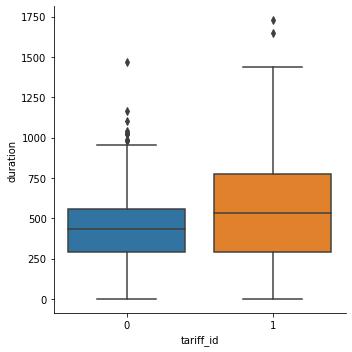

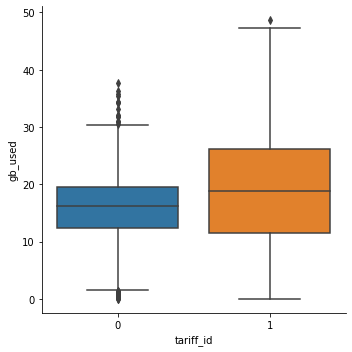

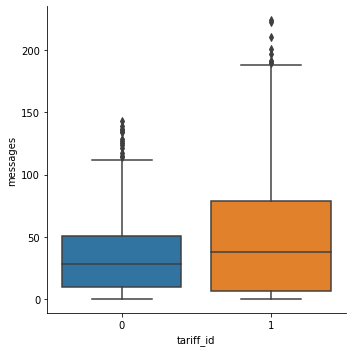

In [37]:
import seaborn as sns
for column in ['duration', 'gb_used', 'messages']:    
    sns.catplot(x="tariff_id", y=column, kind="box", data=all_services, orient='v')

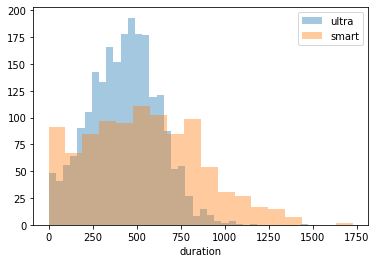

In [38]:
for tariff in range(2):
    sns.distplot(all_services.query('tariff_id == @tariff')['duration'], kde=False)
_ = plt.legend(['ultra', 'smart'])

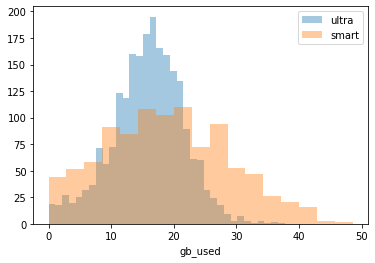

In [39]:
for tariff in range(2):
    sns.distplot(all_services.query('tariff_id == @tariff')['gb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])

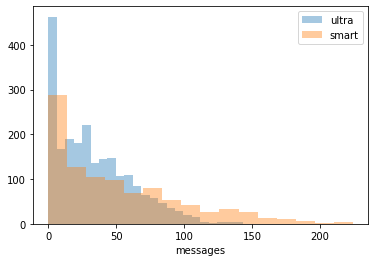

In [40]:
for tariff in range(2):
    sns.distplot(all_services.query('tariff_id == @tariff')['messages'], kde=False)
_ = plt.legend(['ultra', 'smart'])

Межквартильный размах шире у тарифа Ультра - это говорит о бОльшей неоднородности среди пользователей, чем у более простого Смарта, также у Ультра меньше выбросов. Медианы также имеют большее значение у более дорогого тарифа.

Скорее всего это связано с тем, что клиенты с  более дорогим тарифом могут не задумываться о затраченных минутах, и говорить столько, сколько необходимо, а клиенты с более простым тарифом вынуждены время от времени экономить и укладывать свои потребности в те рамки, которые предоставляет тариф.

# 4. Проверка гипотез

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
- H0 - гипотеза о том, что средние наших выборок равны. 
- H1 гипотезой будет наша гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Критический уровень значимости заддадим 0.05. Таким образом вероятность правильности вывода 95% и больше.

In [62]:
from scipy import stats as st
alpha = 0.05
ultra = ultra_per_month['revenue']
smart = smart_per_month['revenue']
results = st.ttest_ind(smart, ultra, equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 6.010629686363275e-08
Отвергаем нулевую гипотезу


Значение p-lavue свидетельствует о малой вероятности случайного совпадения средних по тарифам. Значит отвергаем нулевую гипотезу и можем сказать, что с 95% вероятностью средние значения выручки по тарифам не совпадут.

Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионовю

- H0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
- H1 - средняя выручка пользователей из Москвы отличается средней выручке пользователей из других регионов. 

Критический уровень значимости заддадим 0.05. Таким образом вероятность правильности вывода 95% и больше.

In [63]:
#создадим две таблицы, в одной будут все клиенты из москвы, во второй - все остальные
citys = all_services.merge(users.loc[: , ['user_id', 'city']], on='user_id')

moscow = citys.query('city == "Москва"')['revenue']
regions = citys.query('city != "Москва"')['revenue']

alpha = 0.05
results = st.ttest_ind(moscow, regions, equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.560259602740345
Не получилось отвергнуть нулевую гипотезу


Полученное значение достаточно высоко, это говорит нам о том, что нулевая гипотеза не может быть отвергнута.

**Общий вывод**

После подготовки данных мы сформировали необходимые нам сводные таблицы для анализа. Посчитали по месяцам прибыль по каждому клиенту для компании, в разрезе тарифа и региона(Москва/регионы). Проверили две поставленных гипотезы:

- средняя прибыльность двух тарифов различается
- прибыль от тарифа Ультра выше прибыли по тарифу Смарт


*Резюмируя ответ на вопрос "Какой тариф лучше?" с учётом анализа и проверки гипотез можем сказать: для оператора выгоднее тариф Ультра, так как он приносит больше прибыли за каждого пользователя, а для пользователя выгоднее тариф Смарт, так как по большей части польхователи Смарт укладываются в рамки тарифа.*